In [1]:
### FIX LINK FOR FUNCTIONS WHEN PUSH TO MASTER ###

In [31]:
import sys
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime

from trump import load, treat, text

from gensim.models.word2vec import Word2Vec 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from vaderSentiment import vaderSentiment

plots_args = {'fontsize': 14, 'color': '#9370DB'}
FIGURE_FOLDER = '../history/figures/'

In [2]:
df = load.load_tweets()

check function [load_tweets](https://github.com/liabifano/project/blob/master/trump/src/trump/load.py#L16)

In [3]:
df['clean_tokens'], df['clean_text'] = text.clean_series(df['text'])

check function [clean_series](https://github.com/liabifano/project/blob/master/trump/src/trump/text.py)

# Writing Style

In [4]:
### TODO: DESCRIBE ###

### Over time

In [5]:
def plot_interval_by_cohort(df, cohort, metric, color):
    agg = (df
           .sort_values('first_day_month_cohort')
           .groupby(cohort)
           .describe()[metric])
    
    agg['lower_bound'] = agg['mean'] - 2*agg['std'] / np.sqrt(agg['count'])
    agg['upper_bound'] = agg['mean'] + 2*agg['std'] / np.sqrt(agg['count'])
    
    agg['lower_bound'].plot(linestyle=':', color=c, alpha=0.7, legend=False, label='_nolegend_');
    agg['upper_bound'].plot(linestyle=':', color=c, alpha=0.7, legend=False, label='_nolegend_');
    agg['mean'].plot(linestyle='-', linewidth=3, fontsize=20, color=c, legend=True);
    
    plt.title('Writing style by Quarter'.format(metric), fontsize=20); 
    plt.xlabel('Time', fontsize=20); plt.ylabel('Mean', fontsize=20);

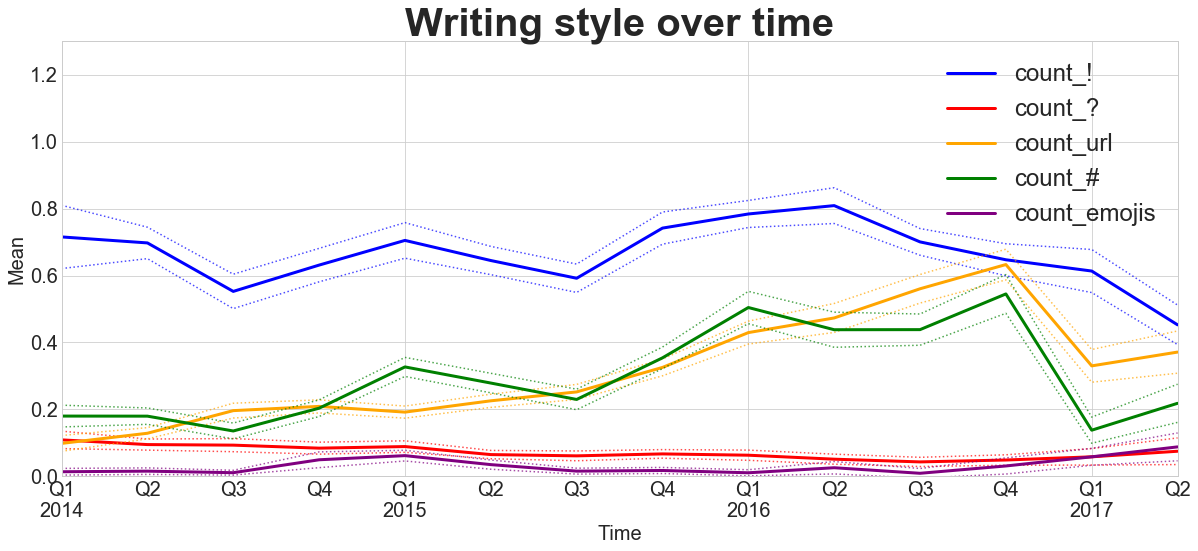

In [6]:
metric_writing_style = [('count_!', 'blue'),
                        ('count_?', 'red'), 
                        ('count_url', 'orange'),
                        ('count_#', 'green'),
                        ('count_emojis', 'purple')]

filtered = df[(df['first_day_month_cohort'] > datetime(2014,1,1)) & 
              (df['first_day_month_cohort'] < datetime(2017, 5, 30))]

plt.figure(figsize=(20,8))
for m, c in metric_writing_style:
    plot_interval_by_cohort(filtered, 'quarter_cohort', m, c)
    plt.ylim([0, 1.3])
    plt.plot()
plt.legend(list(map(lambda x: x[0], metric_writing_style)), loc=1, fontsize=24);
plt.title('Writing style over time', fontsize=40, fontweight='bold'); 
plt.savefig(FIGURE_FOLDER + 'writing_style_over_time.png')

In [7]:
### TODO: COMMENT ###

In [8]:
tags = text.count_tags(df['clean_tokens'])
df = pd.concat([df, tags], axis=1)

check [count_tags]()

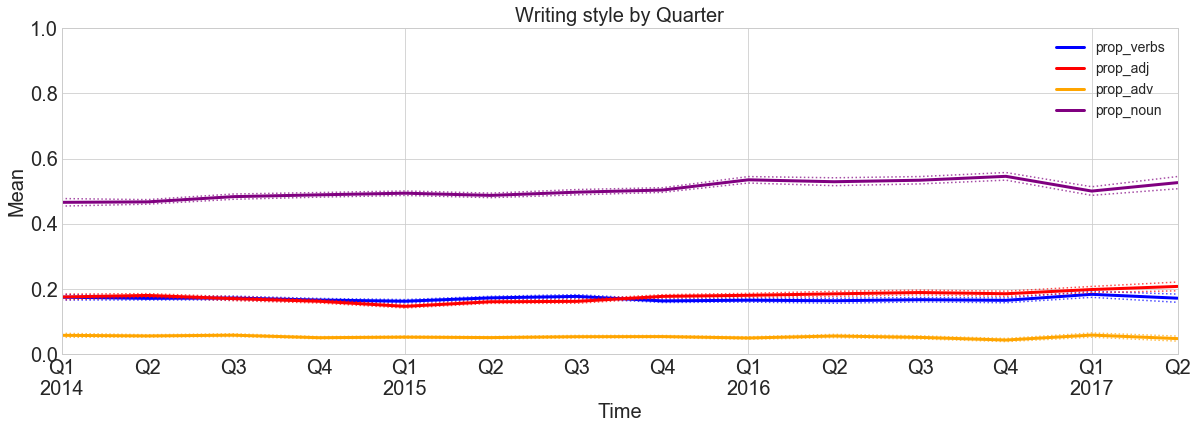

In [9]:
tags_writing_style = [('prop_verbs', 'blue'), 
                      ('prop_adj', 'red'),
                      ('prop_adv', 'orange'), 
                      ('prop_noun', 'purple')]

filtered = df[(df['first_day_month_cohort'] > datetime(2014,1,1)) & 
              (df['first_day_month_cohort'] < datetime(2017, 5, 30))]

plt.figure(figsize=(20,6))
for m, c in tags_writing_style:
    plot_interval_by_cohort(filtered, 'quarter_cohort', m, c)
    plt.ylim([0, 1])
    plt.plot()
plt.legend(list(map(lambda x: x[0], tags_writing_style)), loc=1, fontsize=14);

In [10]:
### TODO: COMMENT ###

### by subject

In [11]:
df = text.get_hardcoded_subjects(df)
subjects = ['hillary', 'obama', 'make_america', 'war', 'democra']

Number of tweets with hillary: 987 (3.2 %)


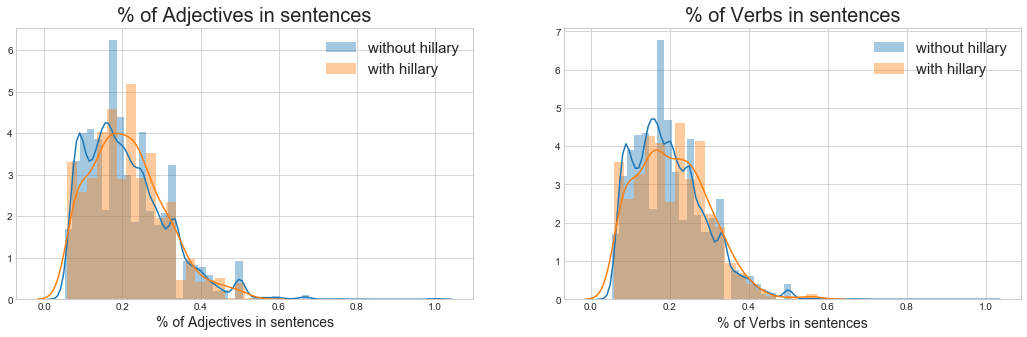

Number of tweets with obama: 2540 (8.1 %)


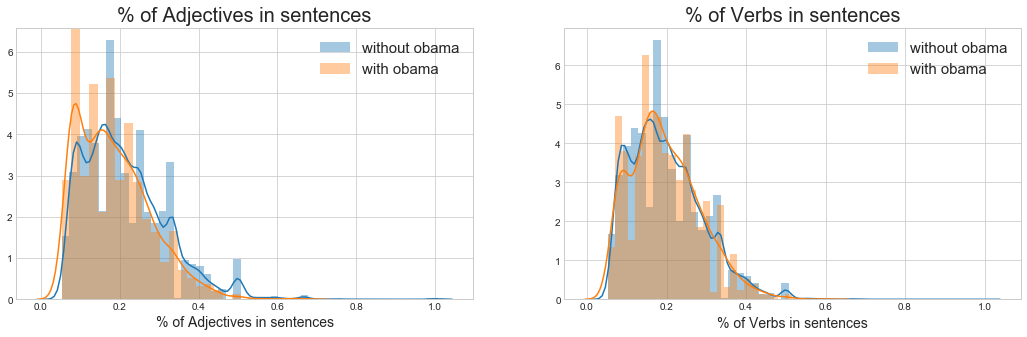

Number of tweets with make_america: 1070 (3.4 %)


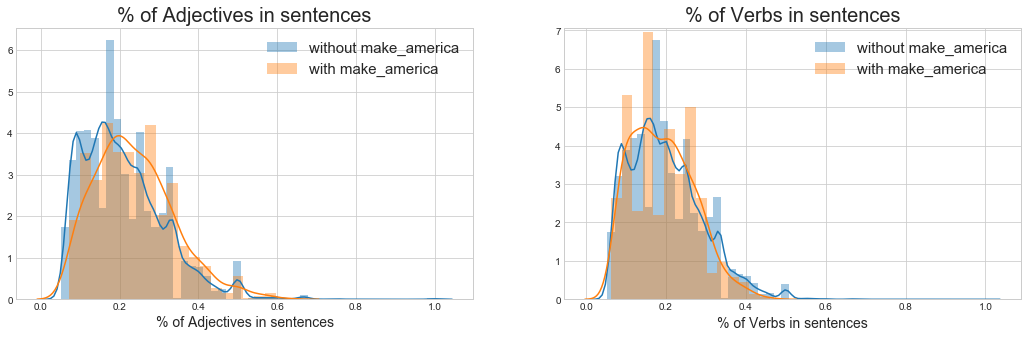

Number of tweets with war: 1165 (3.7 %)


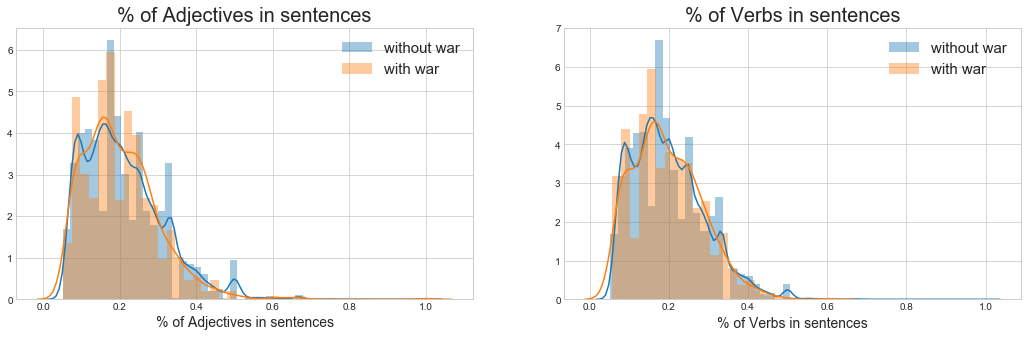

Number of tweets with democra: 218 (0.7 %)


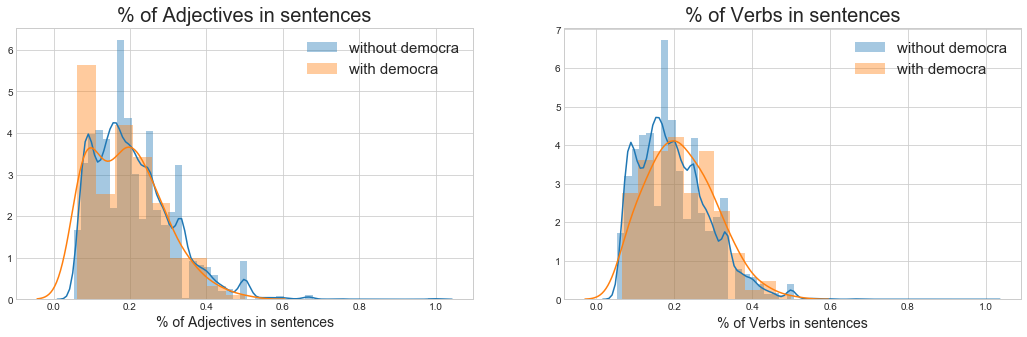

In [12]:
for sub in subjects:
    print('Number of tweets with {}: {} ({} %)'
          .format(sub, df[sub].sum(), 
                  round(100*df[sub].sum()/len(df), 1)))

    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    filtered = df[df['prop_adj'] > 0]
    sns.distplot(filtered.loc[~filtered[sub]]['prop_adj'], ax=ax[0]);
    sns.distplot(filtered.loc[filtered[sub]]['prop_adj'], ax=ax[0]);
    ax[0].legend(['without {}'.format(sub), 'with {}'.format(sub)], loc='best', fontsize=15);
    ax[0].set_title('% of Adjectives in sentences', fontsize=20);
    ax[0].set_xlabel("% of Adjectives in sentences", fontsize=14)
    ax[0].set_title('% of Adjectives in sentences', fontsize=20);

    filtered = df[df['prop_verbs'] > 0]
    sns.distplot(filtered.loc[~filtered[sub]]['prop_verbs'], ax=ax[1]);
    sns.distplot(filtered.loc[filtered[sub]]['prop_verbs'], ax=ax[1]);
    ax[1].legend(['without {}'.format(sub), 'with {}'.format(sub)], loc='best', fontsize=15);
    ax[1].set_xlabel("% of Verbs in sentences", fontsize=14)
    ax[1].set_title('% of Verbs in sentences', fontsize=20);
    
    plt.show()

In [13]:
### TODO: COMMENT ###

### by Device

In [14]:
### TODO: DESCRIBE ###

Out-of-bag score: 69.8%


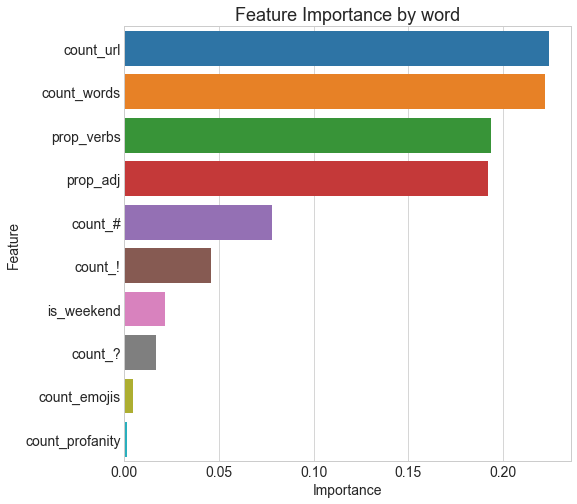

In [15]:
from sklearn.ensemble import RandomForestClassifier

valid_devices = ['Twitter for iPhone', 'Twitter Web Client', 'Twitter for Android']
features = ['is_weekend', 'count_url','count_!', 'count_?', 'count_#', 
            'count_words', 'count_emojis', 'count_profanity', 'prop_adj', 
            'prop_verbs']
df_channels = df[(df['source'].apply(lambda x: x in valid_devices)) & 
                 (df['first_day_month_cohort'] > datetime(2016,1,1)) & 
                 (df['first_day_month_cohort'] < datetime(2017, 5, 30))]

def plot_importance_rf(df, features, label):
    clf = RandomForestClassifier(n_estimators=100, 
                                 random_state=189, 
                                 oob_score=True)
    clf.fit(df[features], df[label]);

    importances = clf.feature_importances_
    feat_importance = (pd.DataFrame(list(zip(features, importances)), 
                               columns=['feature', 'importance'])
                  .sort_values('importance', ascending=False))
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.barplot(y='feature', x='importance', 
                     data=feat_importance,
                     saturation=0.8)
    ax.set_title('Feature Importance by word', fontsize=18)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.xlabel('Importance', fontsize=14); plt.ylabel('Feature', fontsize=14);
    print('Out-of-bag score: {s}%'.format(s=100*round(clf.oob_score_, 3)));
    ax;
    
plot_importance_rf(df_channels, features, 'source')

In [16]:
### TODO: COMMENT ###

In [17]:
df_channels['source'].unique()

array(['Twitter for iPhone', 'Twitter for Android', 'Twitter Web Client'], dtype=object)

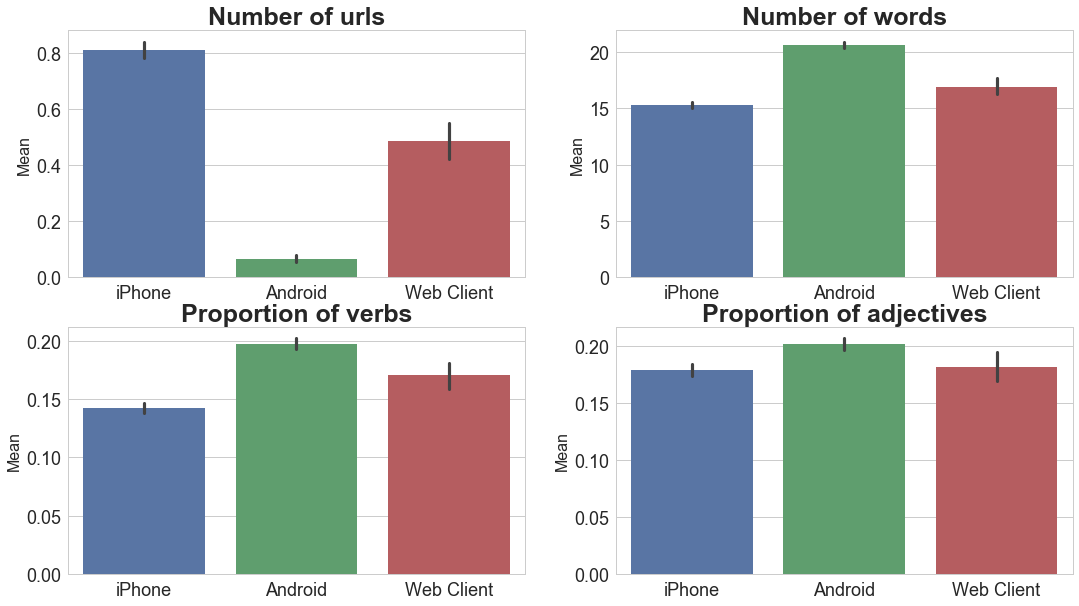

In [18]:
relevant_features = ['count_url', 'count_words', 'prop_verbs', 'prop_adj']
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
nice_lookup = {
    'count_url': 'Number of urls',
    'count_words': 'Number of words',
    'prop_verbs': 'Proportion of verbs',
    'prop_adj': 'Proportion of adjectives'
}
nice_sources = {
    'Twitter for iPhone': 'iPhone',
    'Twitter for Android': 'Android',
    'Twitter Web Client': 'Web Client'
}

df_channels['nice_source'] = df_channels['source'].apply(lambda x: nice_sources[x])
f, ax = plt.subplots(2, 2, figsize=(18, 10))
positions = np.array(range(4)).reshape(2, 2)

for i, feat in enumerate(relevant_features): 
    pos = np.where(positions==i)
    sns.barplot(x='nice_source', y=feat, data=df_channels, ax=ax[pos[0][0], pos[1][0]])
    ax[pos[0][0], pos[1][0]].set_title(nice_lookup[feat], fontweight='bold', fontsize=25)
    ax[pos[0][0], pos[1][0]].set_xlabel('')
    ax[pos[0][0], pos[1][0]].set_ylabel('Mean', fontsize=16)
plt.savefig(FIGURE_FOLDER + 'writing_style_by_device.png')

In [19]:
### TODO: COMMENT ###

## Word2Vec

In [20]:
### TODO: DESCRIBE ###

In [21]:
tweet_w2v = Word2Vec(size=100, min_count=1)
tweet_w2v.build_vocab([x for x in list(list(df['clean_tokens']))])
tweet_w2v.train([x for x in list(df['clean_tokens'])], 
                epochs=tweet_w2v.iter,
                total_examples=tweet_w2v.corpus_count)
word_vectors = tweet_w2v.wv
print('Number of words: {}'.format(len(word_vectors.vocab)))

Number of words: 43258


In [22]:
context_words = ['america', 'democrats', 'republicans',
                 'hillary', 'obama', 
                 'war', 
                 'russia', 'china', 'iran', 'syria', 'brazil', 'mexico',
                 'cnn', 'fake', 'crooked']

contexts = pd.DataFrame()
for w in context_words:
    context = pd.DataFrame([x[0] for x in word_vectors.most_similar(w)], columns=[w])
    contexts = pd.concat([contexts, context], axis=1)
contexts

,america,democrats,republicans,hillary,obama,war,russia,china,iran,syria,brazil,mexico,cnn,fake,crooked
0,minds,fact,stop,crooked,handed,health,isis,barackobama,iraq,putin,financial,credit,network,boring,clinton
1,america…,rigged,putin,beat,turnout,free,oil,syria,trade,stop,across,border,hours,sorry,beat
2,offense,drop,syria,clinton,self-funding,establishment,fact,stop,u.s.,unless,choice,court,ratings,patient,bernie
3,financially,votes,u.s.,obama,vladimir,send,gone,isis,oil,republicans,veterans,free,unwatchable,turning,said
4,together,politicians,negotiate,dysfunctional,unqualified,laws,allowed,incompetent,stupid,use,owner,less,watching,hit,neither
5,magnet,incompetent,capable,said,barack,tax,iraq,republicans,russia,incompetent,example,nuclear,foxnews,lawyer,judgement
6,safe,isis,create,appoint,tougher,repeal,votes,iraq,isis,care,storm,troops,morning_joe,looked,e-mail
7,makers,rather,politicians,antics,china,countries,involved,must,money,politicians,washington,drive,discuss,cover,beaten
8,partial,russia,actually,choked,said,enemy,democrats,wants,negotiate,destroy,enforcement,may,clock,guys,choked
9,country,use,unless,bernie,election2016,lower,gotten,iran,politicians,negotiate,estate,build,slot,talking,hillary


In [23]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

word_vectors = [tweet_w2v[w] for w in list(tweet_w2v.wv.vocab.keys())[:5000]]

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:5000]

plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 1.509s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.015490
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.675133
[t-SNE] Error after 1000 iterations: 1.207056


In [24]:
# NOT A LOT TO SEE HERE 

In [25]:
vectorizer = TfidfVectorizer(min_df=10, analyzer=lambda x: x, max_features=10000, ngram_range=(1, 2))
tfidf = vectorizer.fit_transform(list(df['clean_tokens']))

tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

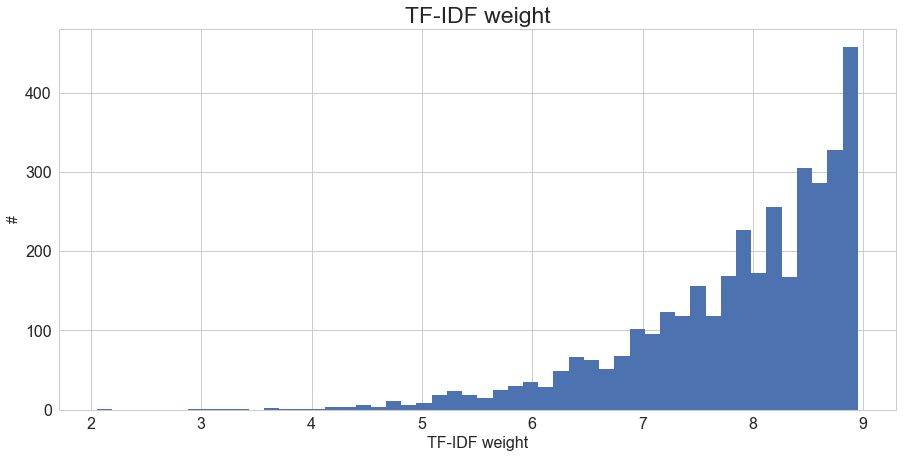

In [26]:
tfidf.tfidf.hist(bins=50, figsize=(15,7));
plt.xlabel('TF-IDF weight', fontsize=16); plt.ylabel('#', fontsize=14)
plt.xticks(fontsize=16); plt.yticks(fontsize=16);
plt.title('TF-IDF weight', fontsize=23);

In [27]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

,tfidf
'',2.053833
http,2.958025
great,3.129110
's,3.292231
https,3.397063
n't,3.607441
thanks,3.707410
--,3.800945
president,3.849551
obama,4.093383


In [28]:
# HERE WE SEE WHAT NEEDS TO BE  CLEANED!!! 
# '', http, 's https, n't, --

In [29]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
slot,8.951079
warrior,8.951079
editor,8.951079
miles,8.951079
broadcast,8.951079
upon,8.951079
bright,8.951079
kimguilfoyle,8.951079
silence,8.951079
brexit,8.951079


In [30]:
tfidf.iloc[-2:]

,tfidf
🇺🇸,7.981679
👍,8.353242


## Sentimental Analysis

In [96]:
def return_sentiment(x):
    if x <= -0.25:
        return 'Negative'
    elif x >= 0.5:
        return 'Positive'
    else :
        return 'Neutral'

In [97]:
analyzer = vaderSentiment.SentimentIntensityAnalyzer()
df['sentiment_raw_score'] = df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_raw_score'].apply(lambda x: return_sentiment(x))

In [214]:
pd.options.display.max_colwidth = 140
df.head(25)[['text', 'sentiment', 'sentiment_raw_score']]

,text,sentiment,sentiment_raw_score
1287,Will be speaking with Germany and France this morning.,Neutral,0.0000
1288,"America's men &amp; women in uniform is the story of FREEDOM overcoming OPPRESSION, the STRONG protecting the WEAK, &amp; G… https://t.c...",Positive,0.7456
1289,"Stock Market at all time high, unemployment at lowest level in years (wages will start going up) and our base has never been stronger!",Negative,-0.7891
1290,The dishonest media will NEVER keep us from accomplishing our objectives on behalf of our GREAT AMERICAN PEOPLE!… https://t.co/EwnwCeuGMv,Neutral,0.3453
1291,#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg,Neutral,0.0000
1292,"We will always take care of our GREAT VETERANS. You have shed your blood, poured your love, and bared your soul, in… https://t.co/bTPuer...",Positive,0.9222
1293,My use of social media is not Presidential - it’s MODERN DAY PRESIDENTIAL. Make America Great Again!,Positive,0.6588
1294,I am thinking about changing the name #FakeNews CNN to #FraudNewsCNN!,Neutral,0.0000
1295,"....the 2016 election with interviews, speeches and social media. I had to beat #FakeNews, and did. We will continue to WIN!",Positive,0.7027
1296,"The FAKE &amp; FRAUDULENT NEWS MEDIA is working hard to convince Republicans and others I should not use social media - but remember, I ...",Negative,-0.5549


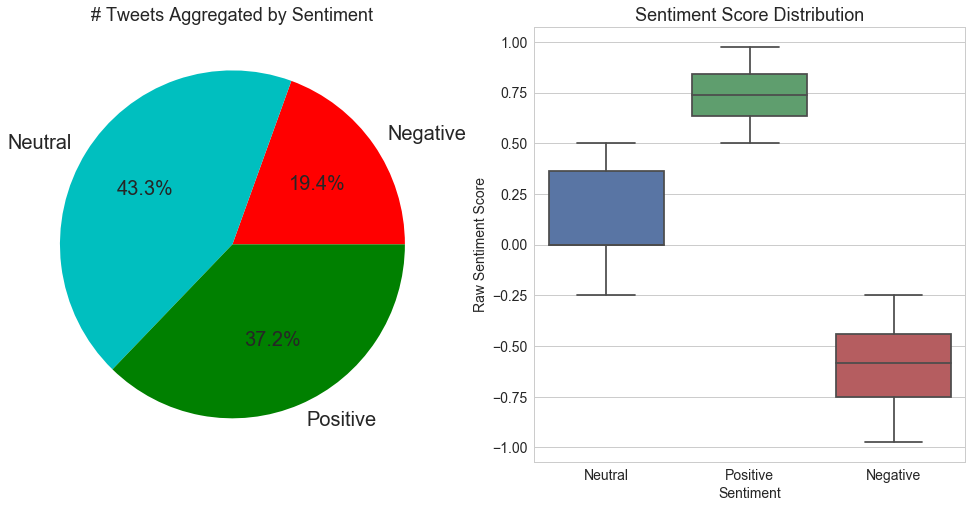

In [213]:
fig = plt.figure()
ax = fig.add_subplot(121)
count_by_sentiment = df[df['created_at'].apply(lambda x: x.year >= 2015)].groupby(['sentiment']).size()
count_by_sentiment.plot(figsize=(17, 8), kind='pie', autopct='%1.1f%%', fontsize=20, colors=['r', 'c', 'g']);
plt.title('# Tweets Aggregated by Sentiment', fontsize=18); 
#plt.xlabel('Sentiment', fontsize=14); 
plt.ylabel('', fontsize=14);


ax = fig.add_subplot(122)
ax = sns.boxplot(y='sentiment_raw_score', x='sentiment', data=df[df['created_at'].apply(lambda x: x.year >= 2015)], showfliers=False);
#sx = sns.distplot(df[df['created_at'].apply(lambda x: x.year >= 2015)]['sentiment_raw_score'])
plt.title('Sentiment Score Distribution', fontsize=18);
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Sentiment', fontsize=14); plt.ylabel('Raw Sentiment Score', fontsize=14);

plt.savefig(FIGURE_FOLDER + 'sentiment_counts.png')
#boxplot

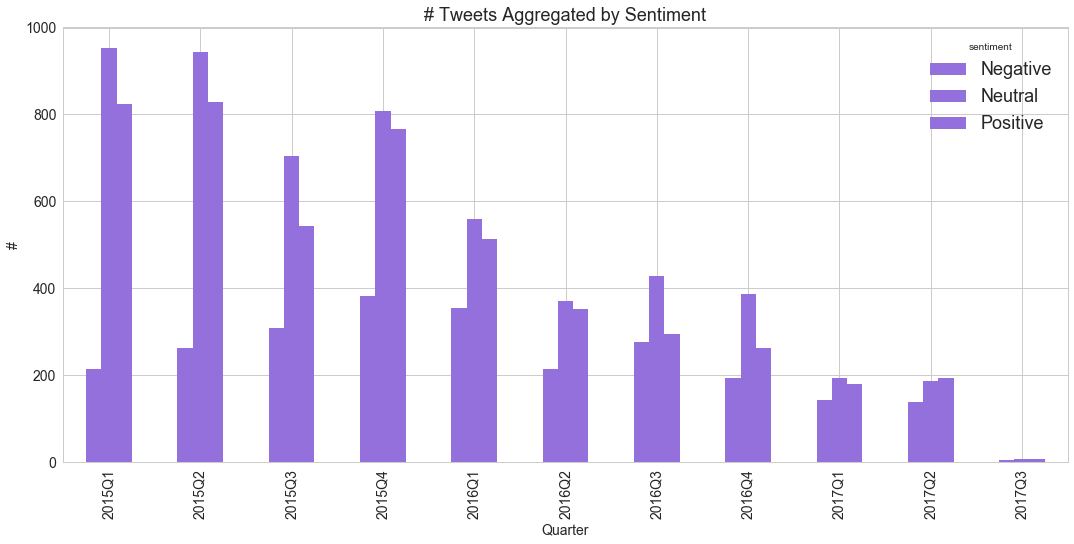

In [216]:
count_by_sentiment_quarter = (df[df['created_at'].apply(lambda x: x.year >= 2015)].groupby(['quarter_cohort', 'sentiment'])
                              .size().unstack().fillna(0).
                              plot(figsize=(18, 8), kind='bar', width=0.5, **plots_args));
plt.title('# Tweets Aggregated by Sentiment', fontsize=18); 
plt.xlabel('Quarter', fontsize=14); plt.ylabel('#', fontsize=14);
plt.savefig(FIGURE_FOLDER + 'sentiment_counts_quarter.png')
#fix colours

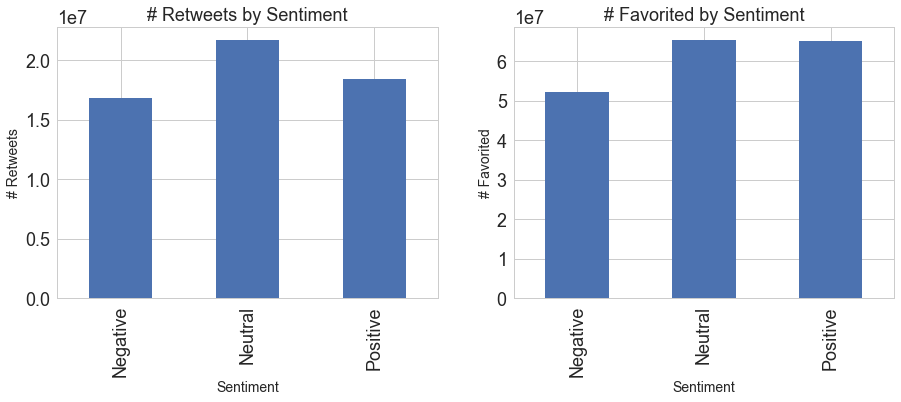

In [221]:
fig = plt.figure()
ax = fig.add_subplot(121)
retweet_count_by_sentiment = (df[df['created_at'].apply(lambda x: x.year >= 2015)]
                              .groupby('sentiment')['retweet_count']
                              .sum().plot(kind='bar', figsize=(15,5)))
#count_by_sentiment.plot(figsize=(10, 6), kind='bar', **plots_args);
plt.title('# Retweets by Sentiment', fontsize=18); 
plt.xlabel('Sentiment', fontsize=14); plt.ylabel('# Retweets', fontsize=14);

ax = fig.add_subplot(122)
favorited_count_by_sentiment = (df[df['created_at'].apply(lambda x: x.year >= 2015)]
                                .groupby('sentiment')['favorite_count']
                                .sum().plot(kind='bar', figsize=(15,5)))
#count_by_sentiment.plot(figsize=(10, 6), kind='bar', **plots_args);
plt.title('# Favorited by Sentiment', fontsize=18); 
plt.xlabel('Sentiment', fontsize=14); plt.ylabel('# Favorited', fontsize=14);
plt.savefig(FIGURE_FOLDER + 'sentiment_retweet_favorited.png')

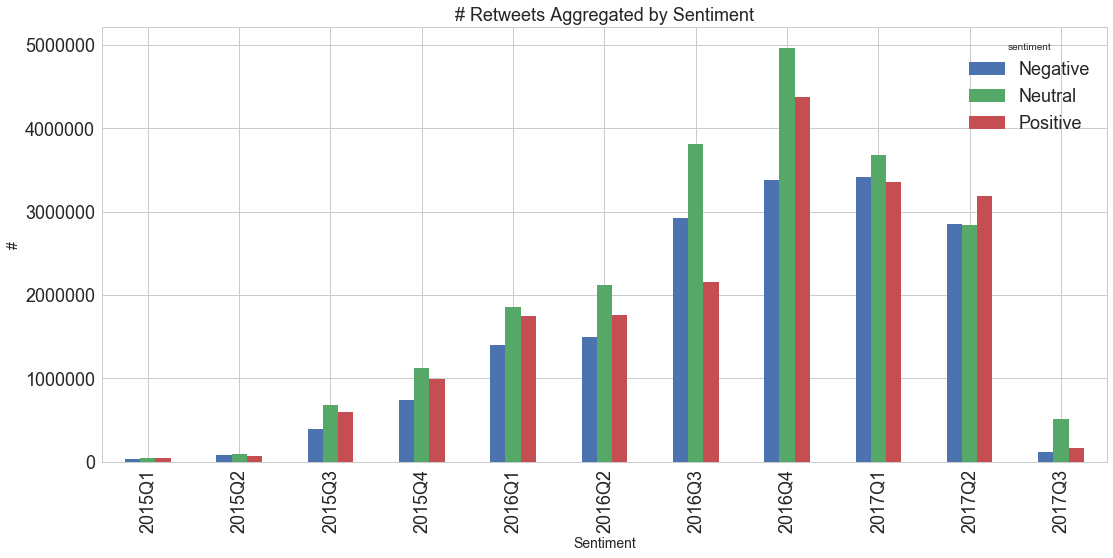

In [222]:
retweet_count_by_sentiment_quarter = (df[df['created_at'].apply(lambda x: x.year >= 2015)]
                                      .groupby(['quarter_cohort', 'sentiment'])['retweet_count']
                                      .sum().unstack().plot(figsize=(18, 8), kind='bar'))
plt.title('# Retweets Aggregated by Sentiment', fontsize=18); 
plt.xlabel('Sentiment', fontsize=14); 
plt.ylabel('#', fontsize=14);
plt.savefig(FIGURE_FOLDER + 'sentiment_retweets_quarter.png')

### Sentiment-Source Analysis

In [113]:
top_devices[1:3]

Index(['Twitter Web Client', 'Twitter for iPhone'], dtype='object', name='source')

In [225]:
top_devices = (df.groupby('source').size()
               .sort_values(ascending=False).index)

In [226]:
top_devices

Index(['Twitter for Android', 'Twitter Web Client', 'Twitter for iPhone',
       'TweetDeck', 'TwitLonger Beta', 'Instagram', 'Facebook',
       'Twitter for BlackBerry', 'Twitter Ads', 'Mobile Web (M5)',
       'Twitlonger', 'Twitter for iPad', 'Media Studio', 'Twitter QandA',
       'Vine - Make a Scene', 'Periscope', 'Neatly For BlackBerry 10',
       'Twitter Mirror for iPad', 'Twitter for Websites'],
      dtype='object', name='source')

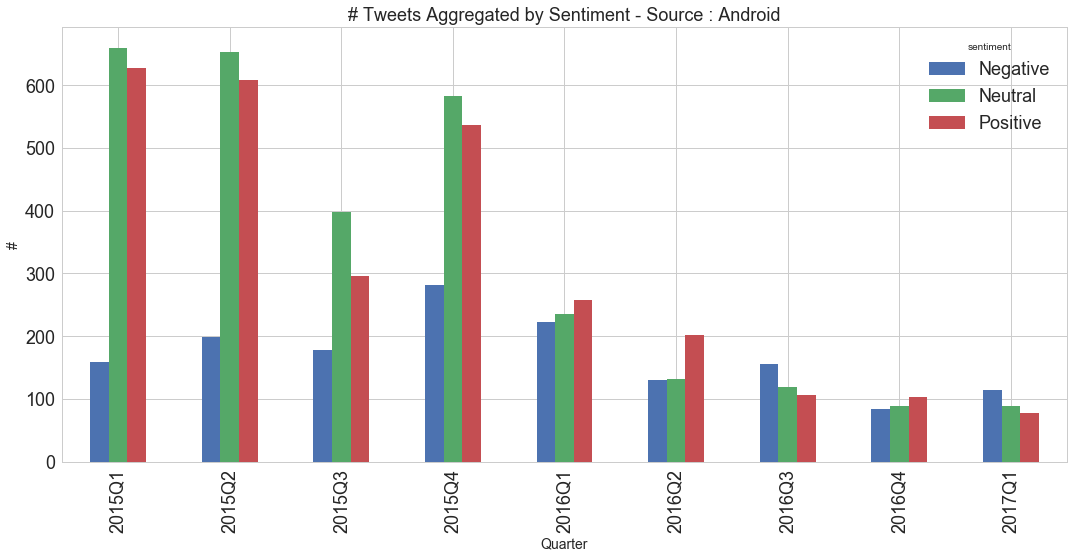

In [224]:
top_devices = (df.groupby('source').size()
               .sort_values(ascending=False)
               .iloc[0:3].index)

#devices_over_time = (df[df['source'].apply(lambda x: x in top_devices)]
pos_count_by_sentiment_quarter = (df[df['created_at'].apply(lambda x: x.year >= 2015)][df['source'].apply(lambda x: x == top_devices[0])]
                                  .groupby(['quarter_cohort', 'sentiment'])
                                  .size().unstack().plot(figsize=(18, 8), kind='bar'))

plt.title('# Tweets Aggregated by Sentiment - Source : Android', fontsize=18); 
plt.xlabel('Quarter', fontsize=14); plt.ylabel('#', fontsize=14);
plt.savefig(FIGURE_FOLDER + 'sentiment_android_quarter.png')
#generate charts for each device showing distribution of tweets based on sentiment

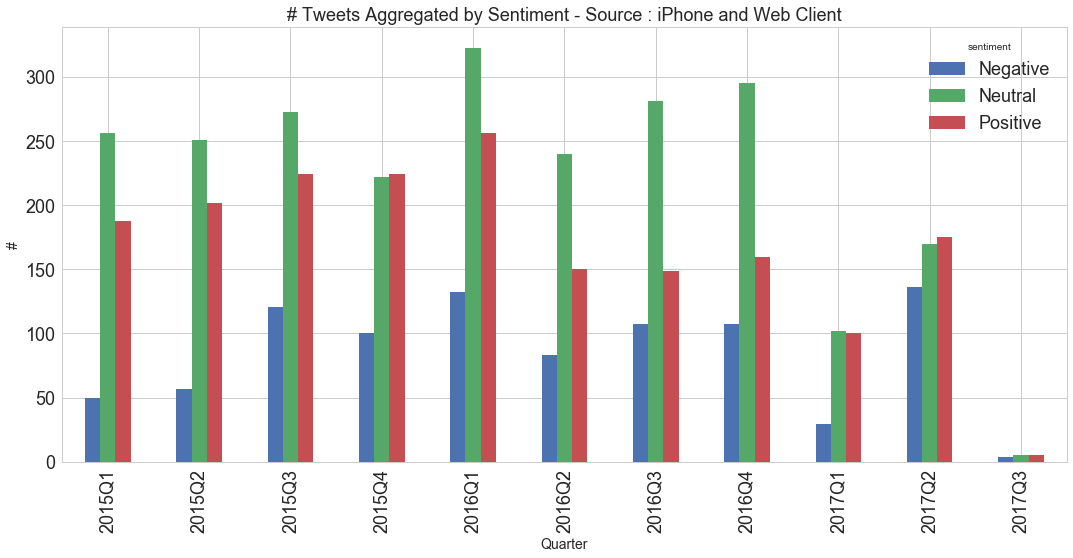

In [223]:
top_devices = (df.groupby('source').size()
               .sort_values(ascending=False)
               .iloc[0:3].index)

#devices_over_time = (df[df['source'].apply(lambda x: x in top_devices)]
pos_count_by_sentiment_quarter = (df[df['created_at'].apply(lambda x: x.year >= 2015)][df['source'].apply(lambda x: x in top_devices[1:3])]
                                  .groupby(['quarter_cohort', 'sentiment'])
                                  .size().unstack().plot(figsize=(18, 8), kind='bar'))

plt.title('# Tweets Aggregated by Sentiment - Source : iPhone and Web Client', fontsize=18); 
plt.xlabel('Quarter', fontsize=14); plt.ylabel('#', fontsize=14);
plt.savefig(FIGURE_FOLDER + 'sentiment_nonandroid_quarter.png')
#generate charts for each device showing distribution of tweets based on sentiment

## Impact Analysis

### Sensational Tweet

In [117]:
sensa = df.sort_values(by='retweet_count', ascending=False)
sensa[['text', 'retweet_count', 'source', 'sentiment']].head(25)

,text,retweet_count,source,sentiment
1291,#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg,369530,Twitter for iPhone,Neutral
2578,TODAY WE MAKE AMERICA GREAT AGAIN!,344806,Twitter for Android,Positive
2566,Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never be...,220796,Twitter for Android,Neutral
4401,"How long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you deleted? https://t.co/gECLNtQizQ",168765,Twitter for iPhone,Neutral
2340,"Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!",141853,Twitter for Android,Negative
28741,The electoral college is a disaster for a democracy.,141644,Twitter Web Client,Negative
1524,Despite the constant negative press covfefe,127507,Twitter for iPhone,Negative
4027,The media is spending more time doing a forensic analysis of Melania's speech than the FBI spent on Hillary's emails.,120661,Twitter Web Client,Neutral
28773,The concept of global warming was created by and for the Chinese in order to make U.S. manufacturing non-competitive.,104633,Twitter Web Client,Neutral
2514,Fidel Castro is dead!,99483,Twitter for Android,Negative


In [127]:
sensa = df.sort_values(by='favorite_count', ascending=False)
sensa[['text', 'favorite_count', 'source', 'sentiment']].head(25)

,text,favorite_count,source,sentiment
2566,Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never be...,633253,Twitter for Android,Neutral
1291,#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg,605098,Twitter for iPhone,Neutral
2578,TODAY WE MAKE AMERICA GREAT AGAIN!,573283,Twitter for Android,Positive
2177,"Peaceful protests are a hallmark of our democracy. Even if I don't always agree, I recognize the rights of people to express their views.",390826,Twitter for Android,Neutral
2340,"Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!",350860,Twitter for Android,Negative
4401,"How long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you deleted? https://t.co/gECLNtQizQ",297281,Twitter for iPhone,Neutral
2183,"THANK YOU for another wonderful evening in Washington, D.C. TOGETHER, we will MAKE AMERICA GREAT AGAIN🇺🇸 https://t.co/V3aoj9RUh4",289942,Twitter for iPhone,Positive
2194,It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS!,268372,Twitter for Android,Neutral
2089,"What an amazing comeback and win by the Patriots. Tom Brady, Bob Kraft and Coach B are total winners. Wow!",267584,Twitter for Android,Positive
1497,"Whatever the United States can do to help out in London and the U. K., we will be there - WE ARE WITH YOU. GOD BLESS!",266026,Twitter for iPhone,Positive


In [151]:
df_sorted = df.sort_values(by='created_at')
df_sorted['increase_followers'] = df_sorted['user.followers_count'] - df_sorted['user.followers_count'].shift(-1)

In [152]:
df_sorted.sort_values(by='increase_followers', ascending=False)[['text', 'sentiment', 'source', 'increase_followers']].head(10)

,text,sentiment,source,increase_followers
2157,"of jobs and companies lost. If Mexico is unwilling to pay for the badly needed wall, then it would be better to cancel the upcoming meet...",Negative,Twitter for Android,11588634.0
2142,"Today, we remember the crew of the Space Shuttle Challenger, 31 years later. #NeverForget https://t.co/OhshQsFRfl",Neutral,Twitter for iPhone,11244906.0
2092,I have instructed Homeland Security to check people coming into our country VERY CAREFULLY. The courts are making the job very difficult!,Neutral,Twitter for Android,9988920.0
2087,"I call my own shots, largely based on an accumulation of data, and everyone knows it. Some FAKE NEWS media, in order to marginalize, lies!",Negative,Twitter for Android,9847934.0
2082,"The threat from radical Islamic terrorism is very real, just look at what is happening in Europe and the Middle-East. Courts must act fast!",Negative,Twitter for Android,9754067.0
2541,I worked hard with Bill Ford to keep the Lincoln plant in Kentucky. I owed it to the great State of Kentucky for their confidence in me!,Positive,Twitter for Android,9644901.0
2051,"I am so proud of my daughter Ivanka. To be abused and treated so badly by the media, and to still hold her head so high, is truly wonder...",Positive,Twitter for Android,9243027.0
2008,Join me at 11:00am:\nWatch here: https://t.co/veqKmsGAwf https://t.co/UzndIjIqjM,Neutral,Twitter for iPhone,8763501.0
2002,"Will be having many meetings this weekend at The Southern White House. Big 5:00 P.M. speech in Melbourne, Florida. A lot to talk about!",Neutral,Twitter for Android,8697327.0
1998,HAPPY PRESIDENTS DAY - MAKE AMERICA GREAT AGAIN!,Positive,Twitter for Android,8559668.0


In [153]:
df_sorted.sort_values(by='increase_followers', ascending=True)[['text', 'sentiment', 'source', 'increase_followers']].head(10)

,text,sentiment,source,increase_followers
2156,"Spoke at the Congressional @GOP Retreat in Philadelphia, PA. this afternoon w/ @VP, @SenMajLeader, @SpeakerRyan. Th… https://t.co/s4sTbS...",Neutral,Twitter for iPhone,-11588588.0
2141,I will be interviewed by @TheBrodyFile on @CBNNews tonight at 11pm. Enjoy!,Positive,Twitter for iPhone,-11244954.0
3820,"""@RealJamesWoods: Without absolutely OWNING the liberal media, HillaryClinton wouldn't stand a chance. #VoterFraud and #MSM her only ho...",Neutral,Twitter for Android,-10384522.0
2091,I will be interviewed by @oreillyfactor at 4:00 P.M. (prior to the #SuperBowl Pre-game Show) on Fox Network. Enjoy!,Positive,Twitter for Android,-9988916.0
2086,Will be interviewed on @oreillyfactor tonight at 8:00 P.M.,Neutral,Twitter for Android,-9847973.0
2081,"I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1in terror, no problem!",Negative,Twitter for Android,-9754043.0
2540,"RT @transition2017: President-elect Trump announces selections for Attorney General, National Security Advisor, CIA Director. More here:...",Neutral,Twitter for iPhone,-9644908.0
2050,"Playef golf today with Prime Minister Abe of Japan and @TheBig_Easy, Ernie Els, and had a great time. Japan is very well represented!",Positive,Twitter for Android,-9243042.0
2007,"The FAKE NEWS media (failing @nytimes, @CNN, @NBCNews and many more) is not my enemy, it is the enemy of the American people. SICK!",Negative,Twitter for Android,-8763491.0
2001,"Getting ready to leave for Melbourne, Florida. See you all soon!",Neutral,Twitter for Android,-8697300.0
